## Molecular Pharmacophores

The pharmacophore is an abstracted molecular structure where specific atoms and bonds have been
reduced to a set of key features such has bases, acids, hydrogen bond donors/acceptors, etc.
In this notebook I will show you how you can build your own pharmacophore models with RDKit.

In [1]:
from rdkit import Chem

# these options customize how our molecules will look when displayed
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (300,200)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices=False
IPythonConsole.drawOptions.addStereoAnnotation=True
IPythonConsole.drawOptions.baseFontSize=0.7
IPythonConsole.drawOptions.annotationFontScale=1
IPythonConsole.drawOptions.fixedBondLength=20

# these options suppress RDKit errors
from rdkit import RDLogger
rdlogger = RDLogger.logger()
rdlogger.setLevel(RDLogger.CRITICAL)

### Pharmacophore SMARTS

We want to build a pharmacophore labeling tool. To do that, we need clearly define what we mean by certain pharmacophoric features. Sure, we know a hydrogen bond acceptor when we see one but it can a little tricky to specify it in a way that a computer can understand. This next section is quite long but is a good exercise in writing SMARTS strings. 

In [2]:
# we are focusing on basic groups with pka < 5
# anilines and pyridines can be basic. however, predicting their pka is a
#  difficult problem for another time. for now, we will not include them
nitrogen_base_smarts = [
    'N',
    '!X4',  # quaternary amine
    '!$(N=[#8,#16])',  # nitroso, sulfoximine
    '!$(N#*)',  # nitrile, diazonium
    '!$(N=[#7])',  # diazo
    '!$(NO)',  # hydroxylamine, oxime
    '!$(N[#6,#16]=[#6,#7,#8])',  # enamine, amide, amidine,
                                 #  sulfonamide, sulfonimidamide
    '!$(NC#N)',  # cyanamide
    '!$(N([#6]C#N)CC#N)',  # dimethylnitrile amine
    '!$(N([#6])([#6])[#8][#6])',  # peralkyl hydroxylamine
    '!$(N[#7][#6]=[#8])',  # hydrazine amide
    '!$(N[#7]=[#6])',  # hydrazone
    '!$(N(c)c)',  # diarylamine
    '!$(Nc)',  # anilines
]
nitrogen_base_smarts = f'[{";".join(nitrogen_base_smarts)}]'
print(nitrogen_base_smarts)

# common nitrogen-containing functional groups
nitrogen_functional_groups = [
    'CN',  # primary amine
    'CNC',  # secondary amine
    'CN(C)C',  # tertiary amine
    'C[N+](C)(C)C',  # quaternary amine
    'C=N',  # imine
    'NC=N',  # amidine
    'C=NO',  # oxime
    'CNc1ccccc1',  # aniline
    'CN=[N+]=[N-]',  # azide
    'C[N+](=O)[O-]',  # nitro
    'n1ccccc1',  # pyridine
    'n1c[nH]cc1',  # imidazole
]

[N;!X4;!$(N=[#8,#16]);!$(N#*);!$(N=[#7]);!$(NO);!$(N[#6,#16]=[#6,#7,#8]);!$(NC#N);!$(N([#6]C#N)CC#N);!$(N([#6])([#6])[#8][#6]);!$(N[#7][#6]=[#8]);!$(N[#7]=[#6]);!$(N(c)c);!$(Nc)]


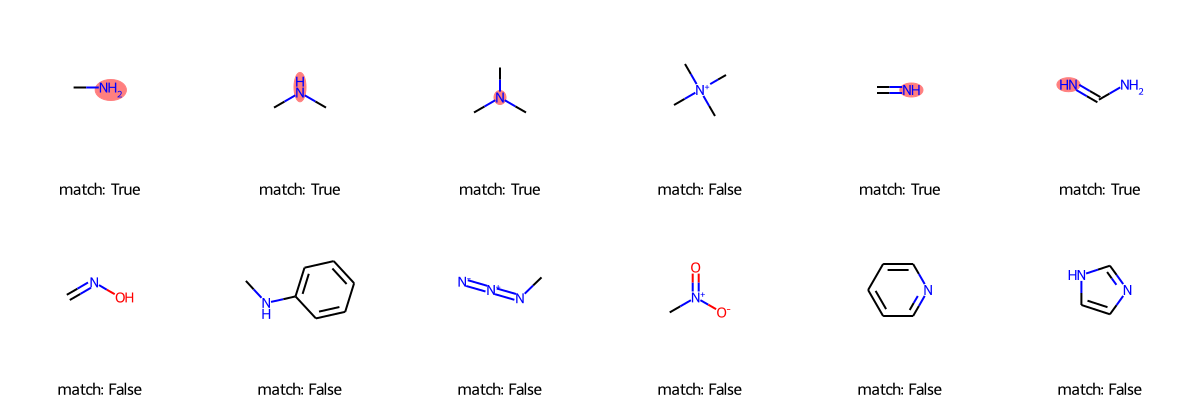

In [3]:
# helper function to assist with visualizing SMARTS strings
def smarts_with_examples(smarts, smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for mol in mols: Chem.Kekulize(mol)
    substruct = Chem.MolFromSmarts(smarts)
    substruct_match = [f'match: {mol.HasSubstructMatch(substruct)}' for mol in mols]
    substruct_indices = [mol.GetSubstructMatch(substruct) for mol in mols]

    return Chem.Draw.MolsToGridImage(
        mols=mols,
        legends=substruct_match,
        highlightAtomLists=substruct_indices,
        molsPerRow=6,
    )

smarts_with_examples(nitrogen_base_smarts, nitrogen_functional_groups)

[OH1;$(OC(=O)),$(OP(=O)),$(OS(=O)),$(OC=CC=O),$(O[#6]=[#7]),$(Oc1=cc(=O)c1=O)]


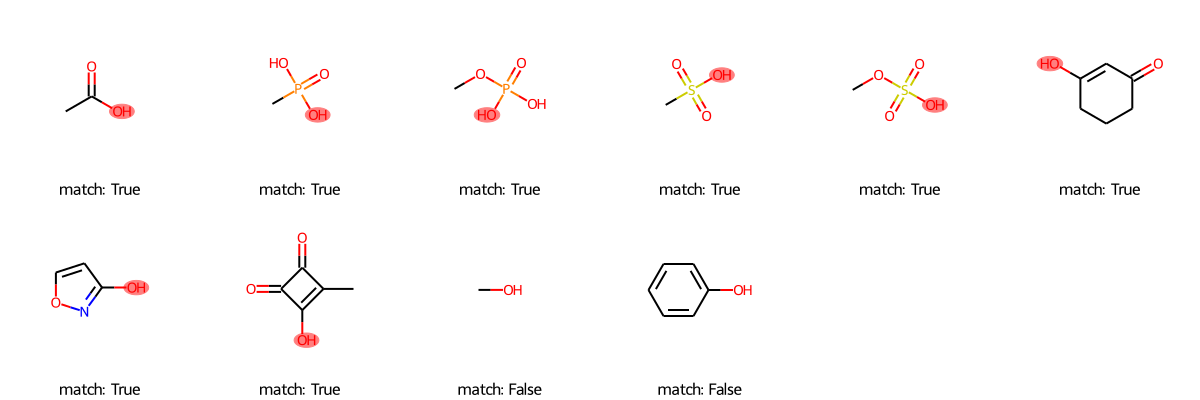

In [4]:
# there are A LOT of acids
# to get a full list, look here: https://doi.org/10.1021/acs.jmedchem.5b01963
# here the cutoff is pka < 7 ish
# phenols can be acidic but that is hard to predict
oxygen_acid_smarts = [
    'OH1;',
    '$(OC(=O))',  # carboxylic acid
    '$(OP(=O))',  # phosphonate, phosphinate
    '$(OS(=O))',  # sulfonate, sulfinate
    '$(OC=CC=O)',  # 1,3-dione enol
    '$(O[#6]=[#7])',  # imidic acid
    '$(Oc1=cc(=O)c1=O)'  # squaric acid
]
oxygen_acid_smarts = f'[{oxygen_acid_smarts[0]}{",".join(oxygen_acid_smarts[1:])}]'
print(oxygen_acid_smarts)

oxygen_functional_groups = [
    'CC(=O)O',  # carboxylic acid
    'CP(=O)(O)O',  # phosphonate
    'COP(=O)(O)O',  # phosphate
    'CS(=O)(=O)O',  # sulfonate
    'COS(=O)(=O)O',  # sulfate
    'C1C(O)=CC(=O)CC1',  # 1,3 dione tautomer
    'n1c(O)cco1',  # hydroxy-isoxazole
    'CC1=C(O)C(=O)C1=O',  # squaric acid
    'CO',  # alcohol
    'c1ccccc1O',  # phenol
]

smarts_with_examples(oxygen_acid_smarts, oxygen_functional_groups)

[#7;H2,H1;$(n1n=nn=c1),$(n1n=nc=n1),$(N([C,S]=[O,S])[C,S]=[O,S])]


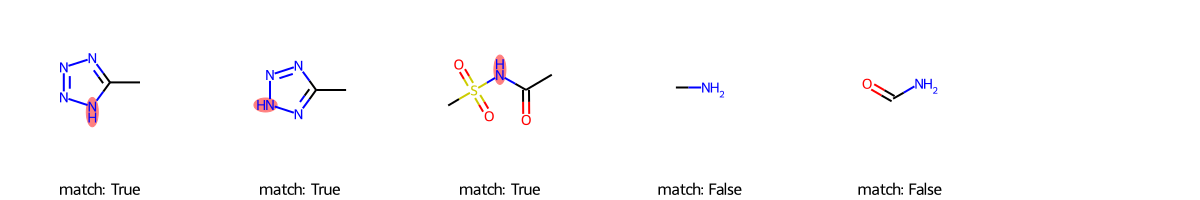

In [5]:
nitrogen_acid_smarts = [
    '#7;H2,H1;',
    '$(n1n=nn=c1)',  # tetrazole
    '$(n1n=nc=n1)',  # tetrazole
    '$(N([C,S]=[O,S])[C,S]=[O,S])',  # acylamide, acylsulfonamide
]
nitrogen_acid_smarts = f'[{nitrogen_acid_smarts[0]}{",".join(nitrogen_acid_smarts[1:])}]'
print(nitrogen_acid_smarts)

nitrogen_functional_groups = [
    'Cc1nnn[nH]1',  # tetrazole
    'Cc1nn[nH]n1',  # tetrazole
    'CC(=O)NS(=O)(=O)C',  # acylsulfonamide
    'CN',  # amine
    'C(=O)N',  # amide
]

smarts_with_examples(nitrogen_acid_smarts, nitrogen_functional_groups)

[#8H,#7H,#7H2]


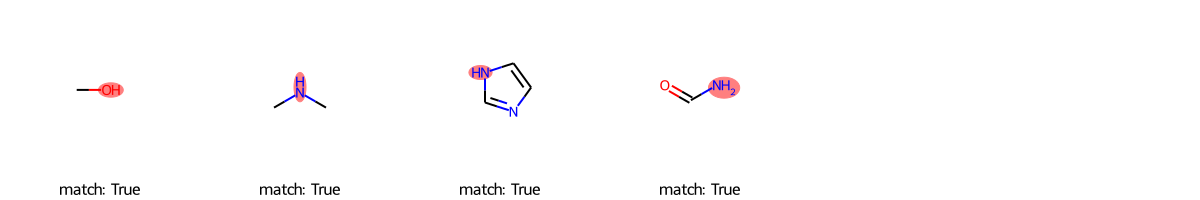

In [6]:
hbd_smarts = '[#8H,#7H,#7H2]'
print(hbd_smarts)

hbd_functional_groups = [
    'CO',
    'CNC',
    'c1c[nH]cn1',
    'O=CN',
]

smarts_with_examples(hbd_smarts, hbd_functional_groups)

[#7;!X4;!$(N=[#8,#16]);!$(N#*);!$(N=[#7]);!$(N[#6,#16]=[#6,#7,#8]);!$(NC#N);!$(Nc);!$([nH])]


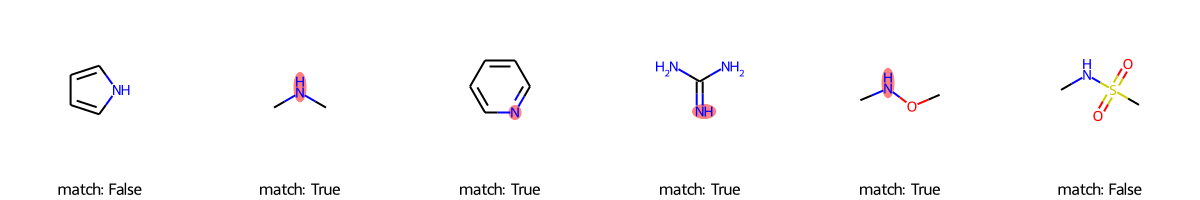

In [7]:
nitrogen_hba_smarts = [
    '#7',
    '!X4',  # quaternary amine
    '!$(N=[#8,#16])',  # nitroso, sulfoximine
    '!$(N#*)',  # nitrile, diazonium
    '!$(N=[#7])',  # diazo
    '!$(N[#6,#16]=[#6,#7,#8])',  # enamine, amide, amidine,
                                 #  sulfonamide, sulfonimidamide
    '!$(NC#N)',  # cyanamide
    '!$(Nc)',  # diarylamine
    '!$([nH])',  # pyrrole nitrogen
]
nitrogen_hba_smarts = f'[{";".join(nitrogen_hba_smarts)}]'
print(nitrogen_hba_smarts)

nitrogen_functional_groups = [
    '[nH]1cccc1',
    'CNC',
    'c1ncccc1',
    'NC(N)=N',
    'CNOC',
    'CNS(=O)(=O)C',
]

smarts_with_examples(nitrogen_hba_smarts, nitrogen_functional_groups)

[O;!$(Oc);!$([O-]N=O);!$(O=N[O-]);!$([O+0]C=O)]


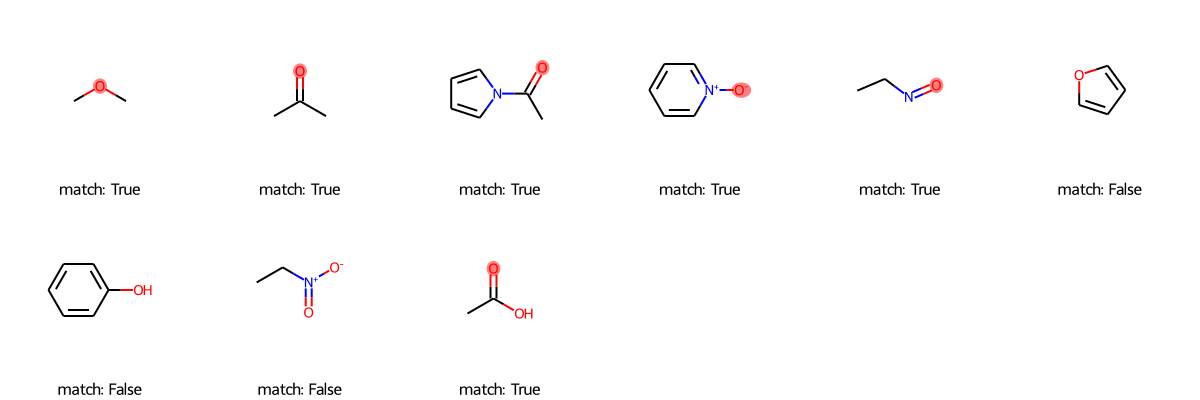

In [8]:
oxygen_hba_smarts = [
    'O',
    '!$(Oc)',  # phenol, arylether
    '!$([O-]N=O)',  # nitro
    '!$(O=N[O-])',  # nitro
    '!$([O+0]C=O)',  # ester
]
oxygen_hba_smarts = f'[{";".join(oxygen_hba_smarts)}]'
print(oxygen_hba_smarts)

oxygen_functional_groups = [
    'COC',
    'CC(=O)C',
    'CC(=O)n1cccc1',
    'c1cccc[n+]1[O-]',
    'CCN=O',
    'c1cocc1',
    'c1ccccc1O',
    'CC[N+]([O-])=O',
    'CC(=O)O',
]

smarts_with_examples(oxygen_hba_smarts, oxygen_functional_groups)

[S;$(S=[#6]);!$(S~[#7,#8])]


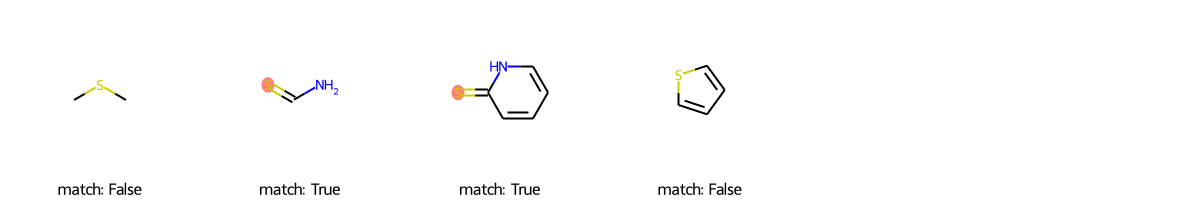

In [9]:
sulfur_hba_smarts = '[S;$(S=[#6]);!$(S~[#7,#8])]'
print(sulfur_hba_smarts)

sulfur_functional_groups = [
    'CSC',
    'C(=S)N',
    'c1c(=S)[nH]ccc1',
    'c1cscc1',
]

smarts_with_examples(sulfur_hba_smarts, sulfur_functional_groups)

[N;!X4;$(Nc);!$(N(c)c)]


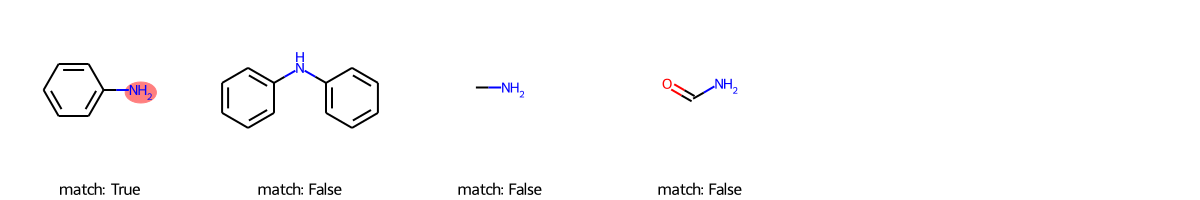

In [10]:
nitrogen_whba_smarts = '[N;!X4;$(Nc);!$(N(c)c)]'
print(nitrogen_whba_smarts)

nitrogen_functional_groups = [
    'Nc1ccccc1',
    'c1ccccc1Nc2ccccc2',
    'CN',
    'NC=O',
]

smarts_with_examples(nitrogen_whba_smarts, nitrogen_functional_groups)

[O;$(Oc),$([O-]N=O),$(O=N[O-]);!$(O(c)c)]


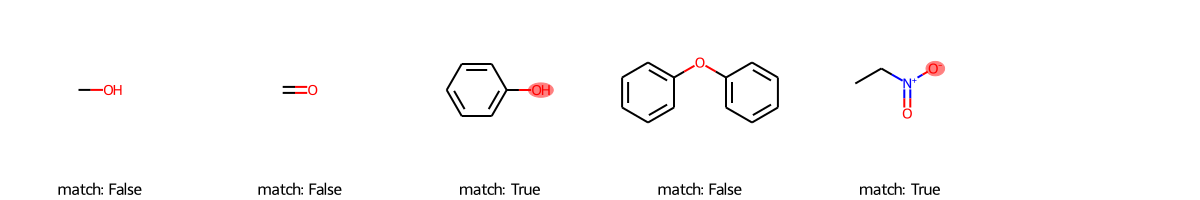

In [11]:
oxygen_whba_smarts = '[O;$(Oc),$([O-]N=O),$(O=N[O-]);!$(O(c)c)]'
print(oxygen_whba_smarts)

oxygen_functional_groups = [
    'CO',
    'C=O',
    'Oc1ccccc1',
    'c1ccccc1Oc2ccccc2',
    'CC[N+]([O-])=O',
]

smarts_with_examples(oxygen_whba_smarts, oxygen_functional_groups)

[S;$([SH]C),$(S(C)C)]


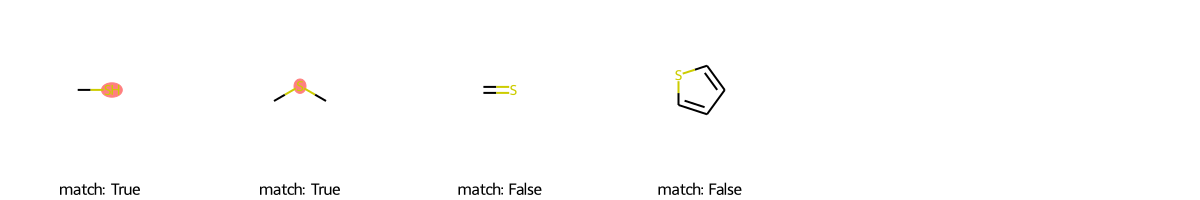

In [12]:
sulfur_whba_smarts = '[S;$([SH]C),$(S(C)C)]'
print(sulfur_whba_smarts)

sulfur_functional_groups = [
    'CS',
    'CSC',
    'C=S',
    'c1cscc1',
]

smarts_with_examples(sulfur_whba_smarts, sulfur_functional_groups)

### Labeling atoms by substructs

Now that we have our SMARTS definitions, we need to label our atoms 

In [13]:
# all our definitions in one place
nitrogen_base_smarts = ('[N;!X4;!$(N=[#8,#16]);!$(N#*);!$(N=[#7]);!$(NO);!$(N[#6,#16]=[#6,#7,#8]);!$(NC#N);!$(N([#6]C#N)CC#N);'
                       '!$(N([#6])([#6])[#8][#6]);!$(N[#7][#6]=[#8]);!$(N[#7]=[#6]);!$(N(c)c);!$(Nc)]')
                       
oxygen_acid_smarts = '[OH1;$(OC(=O)),$(OP(=O)),$(OS(=O)),$(OC=CC=O),$(O[#6]=[#7]),$(Oc1=cc(=O)c1=O)]'
nitrogen_acid_smarts = '[#7;H2,H1;$(n1n=nn=c1),$(n1n=nc=n1),$(N([C,S]=[O,S])[C,S]=[O,S])]'

hbd_smarts = '[#8H,#7H,#7H2]'

nitrogen_hba_smarts = '[#7;!X4;!$(N=[#8,#16]);!$(N#*);!$(N=[#7]);!$(N[#6,#16]=[#6,#7,#8]);!$(NC#N);!$(Nc);!$([nH])]'
oxygen_hba_smarts = '[O;!$(Oc);!$([O-]N=O);!$(O=N[O-]);!$([O+0]C=O)]'
sulfur_hba_smarts = '[S;$(S=[#6]);!$(S~[#7,#8])]'

nitrogen_whba_smarts = '[N;!X4;$(Nc);!$(N(c)c)]'
oxygen_whba_smarts = '[O;$(Oc),$([O-]N=O),$(O=N[O-]);!$(O(c)c)]'
sulfur_whba_smarts = '[S;$([SH]C),$(S(C)C)]'

five_aromatic_smarts = 'a1aaaa1'
six_aromatic_smarts = 'a1aaaaa1'

base_substructs = (
    Chem.MolFromSmarts(nitrogen_base_smarts),
)
acid_substructs = (
    Chem.MolFromSmarts(oxygen_acid_smarts),
    Chem.MolFromSmarts(nitrogen_acid_smarts),
)
hbd_substructs = (
    Chem.MolFromSmarts(hbd_smarts),
)
hba_substructs = (
    Chem.MolFromSmarts(nitrogen_hba_smarts),
    Chem.MolFromSmarts(oxygen_hba_smarts),
    Chem.MolFromSmarts(sulfur_hba_smarts),
)
whba_substructs = (
    Chem.MolFromSmarts(nitrogen_whba_smarts),
    Chem.MolFromSmarts(oxygen_whba_smarts),
    Chem.MolFromSmarts(sulfur_whba_smarts),
)

aromatic_substructs = (
    Chem.MolFromSmarts(five_aromatic_smarts),
    Chem.MolFromSmarts(six_aromatic_smarts),
)

Here is the mol we'll be taking a look at. It has a little something for everyone and represents all the main pharmacophoric features we'll be looking at.

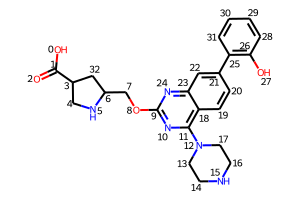

In [14]:
IPythonConsole.drawOptions.addAtomIndices=True

smi = 'OC(=O)C1CNC(COC2=NC(N3CCNCC3)=C3C=CC(=CC3=N2)C2=C(O)C=CC=C2)C1'
mol = Chem.MolFromSmiles(smi)
display(mol)

To find the indices of basic atoms, we use GetSubstructMatches. However, it annoying returns things as a tuple of tuples. So we will need to unpack them into a list for later.

[((5,), (15,))]


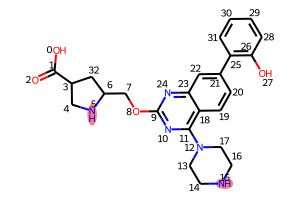

[5, 15]


In [15]:
base_atom_idx = []

for substruct in base_substructs:
    base_atom_idx.append(mol.GetSubstructMatches(substruct))
print(base_atom_idx)

def untuple(atom_idx_tuple, levels=2):
    if levels not in [1, 2]:
        raise ValueError(f'expected levels = 1 or 2, not {levels}')
    atom_idx = []
    for tuple_2 in atom_idx_tuple:
        for tuple_1 in tuple_2:
            if levels == 1:
                atom_idx.append(tuple_1)
            elif levels == 2:
                atom_idx.append(tuple_1[0])
    return atom_idx

base_atom_idx = untuple(base_atom_idx)

display(mol)
print(base_atom_idx)
# clears highlights
mol = Chem.rdchem.Mol(mol)

In [16]:
acid_atom_idx = []
for substruct in acid_substructs:
    acid_atom_idx.append(mol.GetSubstructMatches(substruct))
acid_atom_idx = untuple(acid_atom_idx)

hbd_atom_idx = []
for substruct in hbd_substructs:
    hbd_atom_idx.append(mol.GetSubstructMatches(substruct))
hbd_atom_idx = untuple(hbd_atom_idx)

hba_atom_idx = []
for substruct in hba_substructs:
    hba_atom_idx.append(mol.GetSubstructMatches(substruct))
hba_atom_idx = untuple(hba_atom_idx)

whba_atom_idx = []
for substruct in whba_substructs:
    whba_atom_idx.append(mol.GetSubstructMatches(substruct))
whba_atom_idx = untuple(whba_atom_idx)

# aromatic atoms are different because it's we want to place a dummy atom at the
#  center of the ring. so we keep things as a list of tuples.
aromatic_atom_idx = []
for substruct in aromatic_substructs:
    aromatic_atom_idx.append(mol.GetSubstructMatches(substruct))
aromatic_atom_idx = untuple(aromatic_atom_idx, levels=1)

We don't want overlapping pharmacophoric labels so here we remove them.

In [17]:
for idx in base_atom_idx:
    if idx in hba_atom_idx:
        hba_atom_idx.remove(idx)

for idx in base_atom_idx + hba_atom_idx:
    if idx in whba_atom_idx:
        whba_atom_idx.remove(idx)

for idx in acid_atom_idx:
    if idx in hbd_atom_idx:
        hbd_atom_idx.remove(idx)

For this the next step, we'll need 3D geometries so here we create them first using RDKit, and then refined with xtb.

In [18]:
from conf_utils import get_low_energy_conformer, xtb_geom_opt, display_3d_mol

mol = get_low_energy_conformer(mol, allow_unconverged=True)
display_3d_mol(mol)
mol = xtb_geom_opt(mol)
display_3d_mol(mol)

MMFF94 optimization failed for [H]OC(=O)C1([H])C([H])([H])N([H])C([H])(C([H])([H])Oc2nc(N3C([H])([H])C([H])([H])N([H])C([H])([H])C3([H])[H])c3c([H])c([H])c(-c4c([H])c([H])c([H])c([H])c4O[H])c([H])c3n2)C1([H])[H], raise max_iters


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Coordinate Generation

Now that we know the atom indices for each of our substructures, we need to create 3D coordinates for them so we can display them in 3D.

In [19]:
class XYZ:
    """
    Class for storing and working with xyz coordinates.
    """
    __slots__ = 'x', 'y', 'z'

    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    @staticmethod
    def from_mol_with_idx(mol, atom_idx):
        conf = mol.GetConformer()
        atom_pos = conf.GetAtomPosition(atom_idx)
        return XYZ(atom_pos.x, atom_pos.y, atom_pos.z)
    
    def __add__(self, other):
        return XYZ(
            self.x + other.x,
            self.y + other.y,
            self.z + other.z,
        )
    
    def __truediv__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError('division only supported with int and float')
        return XYZ(
            self.x / other,
            self.y / other,
            self.z / other,
        )

    def __repr__(self):
        return f'{{x: {self.x}, y: {self.y}, z: {self.z}}}'

In [20]:
base_coords = []
for idx in base_atom_idx:
    base_coords.append(XYZ.from_mol_with_idx(mol, idx))

acid_coords = []
for idx in acid_atom_idx:
    atom = mol.GetAtomWithIdx(idx)
    atom_xyz = XYZ.from_mol_with_idx(mol, idx)
    for neighbor in atom.GetNeighbors():
        if neighbor.GetSymbol() == 'H':
            h_xyz = XYZ.from_mol_with_idx(mol, neighbor.GetIdx())
            acid_coords.append((atom_xyz + h_xyz) / 2)

hbd_coords = []
for idx in hbd_atom_idx:
    atom = mol.GetAtomWithIdx(idx)
    atom_xyz = XYZ.from_mol_with_idx(mol, idx)
    for neighbor in atom.GetNeighbors():
        if neighbor.GetSymbol() == 'H':
            h_xyz = XYZ.from_mol_with_idx(mol, neighbor.GetIdx())
            hbd_coords.append((atom_xyz + h_xyz) / 2)

hba_coords = []
for idx in hba_atom_idx:
    hba_coords.append(XYZ.from_mol_with_idx(mol, idx))

whba_coords = []
for idx in whba_atom_idx:
    whba_coords.append(XYZ.from_mol_with_idx(mol, idx))

aromatic_coords = []
for tuple_idx in aromatic_atom_idx:
    center_xyz = XYZ(0.0, 0.0, 0.0)
    for idx in tuple_idx:
        center_xyz += XYZ.from_mol_with_idx(mol, idx)
    center_xyz = center_xyz / len(tuple_idx)
    aromatic_coords.append(center_xyz)

In [21]:
from conf_utils import remove_nonpolar_hs
import py3Dmol

def get_sphere_dict(coord: XYZ, radius, color):
    coord = dict(x=coord.x, y=coord.y, z=coord.z)
    return {
        'center': coord,
        'hidden': False,
        'radius': radius,
        'scale': 1,
        'color': color,
        'opacity': 0.7,
    }

if len(mol.GetConformers()) == 0:
    mol = get_low_energy_conformer(mol, allow_unconverged=True)
    mol = xtb_geom_opt(mol)

mol_block = ''
mol_block = Chem.rdmolfiles.MolToMolBlock(remove_nonpolar_hs(mol),
                                            includeStereo=True)
view = py3Dmol.view(
    data=mol_block,
    width=400,
    height=300,
    style={
        'stick': {
            'colorscheme': f'whiteCarbon',
            'radius':0.25
        }
    }
)
view.setBackgroundColor('#111111')
outline_color = 'white'
view.setViewStyle({'style':'outline','color':outline_color,'width':0.04})

for coord in base_coords:
    view.addSphere(get_sphere_dict(coord, 0.8, 'purple'))
for coord in acid_coords:
    view.addSphere(get_sphere_dict(coord, 0.8, 'yellow'))
for coord in hbd_coords:
    view.addSphere(get_sphere_dict(coord, 0.8, 'orange'))
for coord in hba_coords:
    view.addSphere(get_sphere_dict(coord, 0.8, 'blue'))
for coord in whba_coords:
    view.addSphere(get_sphere_dict(coord, 0.8, 'lightblue'))
for coord in aromatic_coords:
    view.addSphere(get_sphere_dict(coord, 1.3, 'green'))

view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Tada! There's our pharmacophore model!

Unlike some other tutorials, I will not be packaging this into a simple function as it's a little more complex and I should probably turn this into a Python package. I hope you enjoyed this demonstration of the usefulness of SMARTS substructures and the cool things we can do with molecules in 3D.